In [726]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import datetime
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import random
import time
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import math

In [53]:
T = 1

In [883]:
def displacement(t, c1, c2):
    t1, t2 = t
    return c1*T/(2*np.pi) * (np.cos(2*np.pi*t1/T) - np.cos(2*np.pi*t2/T)) + c2*T/(2*np.pi) * (np.sin(2*np.pi*t2/T) - np.sin(2*np.pi*t1/T))

In [884]:
def velocity(t, a, ph):
    return a * np.sin(2*np.pi*(t+ph)/T)

In [885]:
def remove_outliers(cell, v_error):
    threshold = 2.5 * 1.4826 * v_error
    upper_threshold = cell.median(dim='mid_date', skipna=True) + threshold
    lower_threshold = cell.median(dim='mid_date', skipna=True) - threshold
    mask1 = cell <= upper_threshold
    mask2 = cell >= lower_threshold
    mask = mask1 * mask2
    return mask

In [922]:
def remove_interannual_var(cell, mid_dates_cell, v_error_cell, min_date, max_date):
    weighted_vels = np.zeros(max_date - min_date + 1)
    weighted_dates_ord = np.zeros(max_date - min_date + 1)
    cell_years = np.zeros(max_date - min_date + 1)
    masks = []
    i = 0

    for year in range(min_date, max_date+1):
        
        cell_years[i] = year
        year_mask1 = cell.mid_date.values >= np.datetime64(year, 'Y')-1970
        year_mask2 = cell.mid_date.values < np.datetime64(year+1, 'Y')-1970
        year_mask = (year_mask1 * year_mask2)
        masks.append(year_mask)
        
        cell_year = cell.values[year_mask]
        v_error_year = v_error_cell[year_mask]
        first = datetime.date(year, 1, 1).toordinal()
        mid_dates_year = mid_dates_cell[year_mask].astype('M8[ms]').astype('O')
        mid_dates_year = np.array(list(map(datetime.date.toordinal, mid_dates_year))) - first
        
        weights = 1/v_error_year**2
        weighted_cell = weights/sum(weights)*cell_year
        weighted_vels[i] = sum(weighted_cell)

        weighted_date = weights/sum(weights)*mid_dates_year
        weighted_dates_ord[i] = sum(weighted_date)+first
        
        i += 1

    # interpolate a spline fit
    FIRST = min(weighted_dates_ord)
    LAST = max(weighted_dates_ord)
    f = interp1d(weighted_dates_ord, weighted_vels, kind='cubic')
    xnew = np.linspace(FIRST, LAST, num=len(cell_years), endpoint=True)

    ia_var = f(xnew)

    ia_removed = []

    i = 0
    
    for year in range(min_date, max_date+1):
        year_mask1 = cell.mid_date.values >= np.datetime64(year, 'Y')-1970
        year_mask2 = cell.mid_date.values < np.datetime64(year+1, 'Y')-1970
        year_mask = masks[i]

        cell_year = cell[year_mask]
        index = year - cell_years[0]
        removed_ia_var = cell_year - ia_var[int(index)]

        ia_removed.append(removed_ia_var)

        i += 1
    ia_rem = xr.concat(ia_removed, 'mid_date')
    
    return ia_rem

In [1120]:
def predict_params(disp_rem, im1_rem, im2_rem, w):
    param, param_cov = curve_fit(displacement, [im1_rem/365.25, im2_rem/365.25], disp_rem, sigma = w)
    c1, c2 = param
    
    a = math.hypot(c1, c2)
    ph_rad = math.atan2(c2, c1)
    ph = ph_rad/(2*np.pi)
    peak = 365.25*(0.25 - ph_rad/(2*np.pi) % 1)
    
    if peak < 0:
        peak += 365.25
        
    return a, ph, peak

In [888]:
def open_datacube(directory):
    with xr.open_dataset(directory, decode_timedelta=False) as ds:
        data = ds
    return data

In [889]:
greenland_dir = 'data/Greenland_61.6N_48.1W.nc'
gl_cube = open_datacube(greenland_dir)

In [1138]:
gl_cube

<xarray.Dataset>
Dimensions:                    (mid_date: 7073, x: 416, y: 416)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2012-12-30T00:00:00....
  * x                          (x) float64 6.04e+05 6.042e+05 ... 7.036e+05
  * y                          (y) float64 6.887e+06 6.887e+06 ... 6.788e+06
Data variables: (12/42)
    UTM_Projection             <U1 ''
    acquisition_img1           (mid_date) datetime64[ns] 2013-03-26 ... 2015-...
    acquisition_img2           (mid_date) datetime64[ns] 2012-10-06 ... 2014-...
    autoRIFT_software_version  (mid_date) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    chip_size_height           (mid_date, y, x) float32 ...
    chip_size_width            (mid_date, y, x) float32 ...
    ...                         ...
    vy                         (mid_date, y, x) float32 ...
    vy_error                   (mid_date) float64 50.71 73.45 ... 9.84 15.64
    vy_stable_shift            (mid_date) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    vyp                        (mid_date, y, x) float32 ...
    vyp_error                  (mid_date) float64 nan nan nan ... nan nan nan
    vyp_stable_shift           (mid_date) float64 nan nan nan ... nan nan nan
Attributes:
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    datacube_software_version:  1.0
    date_created:               21-06-2021 18:10:46
    date_updated:               21-06-2021 18:10:46
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    projection:                 32622
    title:                      ITS_LIVE datacube of image_pair velocities

In [890]:
all_mid_dates = gl_cube.mid_date

In [891]:
m = all_mid_dates > np.datetime64("2000")

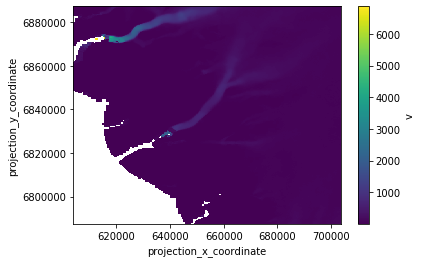

In [14]:
# median velocity
gl_median = gl_cube.v.median(dim='mid_date')
gl_median.plot(x='x', y='y')
plt.show()

In [892]:
sorted_cube = gl_cube.sortby('acquisition_img2') # sort by date of first image taken

In [893]:
v = sorted_cube.v
x = sorted_cube.x
y = sorted_cube.y
mid_dates = sorted_cube.mid_date
im1 = sorted_cube.acquisition_img2
im2 = sorted_cube.acquisition_img1
dts = sorted_cube.date_dt
v_error = np.sqrt(sorted_cube.vx_error**2 + sorted_cube.vy_error**2)
dyr = dts/365.25

In [894]:
v2 = v.stack(grid_cell=("x", "y"))

In [895]:
# make a continuous time range
# times = np.array(list(map(datetime.date.toordinal, sorted_cube.mid_date.values.astype('M8[ms]').astype('O'))))
min_time = datetime.date.toordinal(datetime.date(2000, 1, 1))
max_time = datetime.date.toordinal(datetime.date(2018, 12, 31))
TIMES = np.array(range(min_time, max_time+1))
DATES = np.array(list(map(datetime.date.fromordinal, TIMES)))

In [19]:
amps = np.full(v2.sizes['grid_cell'], np.nan)
phases = np.full(v2.sizes['grid_cell'], np.nan)
peaks = np.full(v2.sizes['grid_cell'], np.nan, dtype=datetime.date)

In [392]:
start = time.time()

In [393]:
discarded = 0
for i in range(v2.sizes['grid_cell']):
    if i%1000==0:
            print(i)

    cell = v2[:, i]
    cell = cell.where(cell.mid_date > np.datetime64("2000")) # only use data from 2000 or later
    
    # remove outliers
    mask = remove_outliers(cell, v_error)
    mask = mask.values

    if np.sum(mask) > 30: 
        cell = cell[mask]
        mid_dates_cell = mid_dates[mask].values
        dts_cell = dts[mask].values
        dyr_cell = dyr[mask].values
        v_error_cell = v_error[mask].values

        w_d = 1/(v_error_cell * dyr_cell)**2
        
        min_date = np.min(mid_dates_cell).astype('M8[ms]').astype('O').year
        max_date = np.max(mid_dates_cell).astype('M8[ms]').astype('O').year

        try:
            ia_removed = remove_interannual_var(cell, mid_dates_cell, v_error_cell, min_date, max_date)
        except:
            print(i)
            raise
        
        m1 = dts_cell > 20
        m2 = dts_cell < 365
        mask2 = m1*m2
        
        if sum(mask2) > 30:
            try:
                removed = ia_removed.values[mask2]
                dyr_cell = dyr_cell[mask2]

                im1_cell = np.array(list(map(datetime.date.toordinal, im1.values[mask].astype('M8[D]').astype('O'))))
                im2_cell = np.array(list(map(datetime.date.toordinal, im2.values[mask].astype('M8[D]').astype('O'))))

                # calculate the displacement of each image pair (not cumulative displacement)
                disp_rem = dyr_cell * removed
                rem_mask = np.isnan(disp_rem) == False
                disp_rem = disp_rem[rem_mask]
                im1_rem = im1_cell[mask2]
                im1_rem = im1_rem[rem_mask]
                im2_rem = im2_cell[mask2]
                im2_rem = im2_rem[rem_mask]
                dts_rem = dyr_cell[rem_mask]
                w_d_rem = w_d[mask2]
                
                a, ph, peak = predict_params(disp_rem, im1_rem, im2_rem, w_d_rem[rem_mask])

                amps[i] = a
                phases[i] = ph
                peaks[i] = peak
                
            except:
                print(i)
                raise
        else:
            discarded += 1
    else:
        discarded += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [394]:
end = time.time()
print(end - start)

5621.474623441696


In [397]:
np.savetxt("amps.csv", amps, delimiter=",")

In [398]:
np.savetxt("phases.csv", phases, delimiter=",")

In [400]:
np.savetxt("peaks.csv", peaks, delimiter=",", fmt='%s')

In [402]:
new_amps = np.reshape(amps, (len(x), len(y)))
all_amps = xr.DataArray(new_amps, dims=("x", "y"), coords={'x':x, 'y':y})

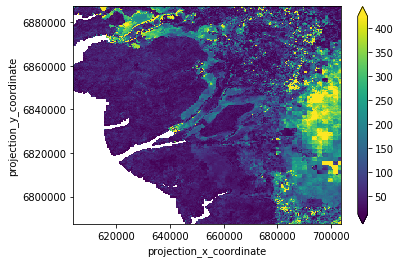

Max amplitude: <xarray.DataArray ()>
array(5829.10397264), Min amplitude: <xarray.DataArray ()>
array(0.05169031)


In [403]:
all_amps.plot(x='x', y='y', robust=True)
plt.show()
print(f"Max amplitude: {np.max(all_amps)}, Min amplitude: {np.min(all_amps)}")

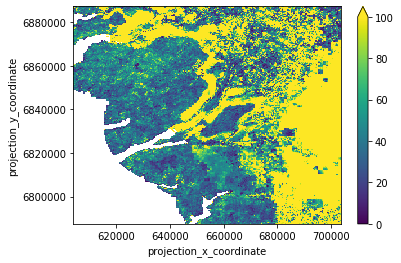

Max amplitude: <xarray.DataArray ()>
array(5829.10397264), Min amplitude: <xarray.DataArray ()>
array(0.05169031)


In [512]:
xr.plot.imshow(all_amps, x='x', y='y', vmin=0, vmax=100)
plt.show()
print(f"Max amplitude: {np.max(all_amps)}, Min amplitude: {np.min(all_amps)}")

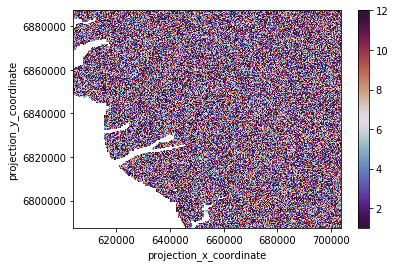

In [405]:
new_peaks = np.array(peaks)
peak_months = np.array([np.nan if type(p) == float else p.month for p in new_peaks])
peak_months = np.reshape(peak_months, (len(x), len(y)))
all_peaks = xr.DataArray(peak_months, dims=("x", "y"), coords={'x':x, 'y':y})

pred_peaks = np.array([np.nan if type(p) == float else p.month for p in peaks])
pred_peaks = np.reshape(peaks, (len(x), len(y)))
pred_peaks = xr.DataArray(peak_months, dims=("x", "y"), coords={'x':x, 'y':y})

all_peaks.plot(x='x', y='y', cmap='twilight_shifted')
plt.show()

In [1059]:
def velocity_sin_scaled(times, amplitude, phase):
    return amplitude * np.sin(2*np.pi/365 * (times + phase))

In [1063]:
def velocity_sin(times, constant, amplitude, phase):
    return constant + amplitude * np.sin(2*np.pi * (times + phase))

In [913]:
def remove_interannual_var_test(cell, mid_dates_cell, v_error_cell, min_date, max_date):
    weighted_vels = np.zeros(max_date - min_date + 1)
    weighted_dates_ord = np.zeros(max_date - min_date + 1)
    
    weights = 1/v_error_cell**2
    as_dates = mid_dates_cell.astype('M8[ms]').astype('O')
    all_years = np.array(list(map(datetime.date.isocalendar, as_dates)))[:,0]
    yday = np.array(list(map(datetime.date.timetuple, as_dates)))[:,-2]
    i = 0
    for year in range(min_date, max_date+1):
        first = datetime.date(year, 1, 1).toordinal()
        ind = all_years == year
        
        if len(weights[ind]) == 0:
            weighted_vels[i] = weighted_vels[i-1]
            weighted_dates_ord[i] = 365/2 + first
        else:
        
            weighted_vels[i] = sum(weights[ind]*cell.values[ind]) / sum(weights[ind])
        
            weighted_dates_ord[i] = (sum(weights[ind]*yday[ind]) / sum(weights[ind])) + first
        
        i += 1
    
#     print(weighted_dates_ord)
    # interpolate a spline fit
    FIRST = min(weighted_dates_ord)
    LAST = max(weighted_dates_ord)
    f = interp1d(weighted_dates_ord, weighted_vels, kind='cubic')
    xnew = np.linspace(FIRST, LAST, num=len(weighted_vels), endpoint=True)
    
    ia_var = f(xnew)
   
#     weighted_dates = list(map(datetime.date.fromordinal, weighted_dates_ord.astype(int)))
    
#     plt.figure(figsize=(20,5))
#     plt.plot(weighted_dates, weighted_vels, 'o', xnew, f(xnew), '-')
#     plt.legend(['data', 'cubic'], loc='best')
#     plt.show()

    ia_removed = []

    i = 0
    
    for year in range(min_date, max_date+1):
        ind = all_years == year

        cell_year = cell[ind]
        index = year - min_date
        removed_ia_var = cell_year - ia_var[int(index)]

        ia_removed.append(removed_ia_var)

        i += 1
    ia_rem = xr.concat(ia_removed, 'mid_date')
    
    return ia_rem

In [1128]:
amps = np.full(v2.sizes['grid_cell'], np.nan)
phases = np.full(v2.sizes['grid_cell'], np.nan)
peaks = np.full(v2.sizes['grid_cell'], np.nan, dtype=datetime.date)

In [1129]:
start = time.time()

In [1130]:
discarded = 0
for i in range(v2.sizes['grid_cell']):
    if i%10000==0:
            print(i, time.time() - start)

    cell = v2[:, i]
    cell = cell.where(cell.mid_date > np.datetime64("2000")) # only use data from 2000 or later

    # remove outliers
    mask = remove_outliers(cell, v_error)
    mask = mask.values

    if np.sum(mask) > 30:
        cell = cell[mask]
        mid_dates_cell = mid_dates[mask].values
        dts_cell = dts[mask].values
        dyr_cell = dyr[mask].values
        v_error_cell = v_error[mask].values

        w_d = 1/(v_error_cell * dyr_cell)
        
        min_date = np.min(mid_dates_cell).astype('M8[ms]').astype('O').year
        max_date = np.max(mid_dates_cell).astype('M8[ms]').astype('O').year
        
        try:
            ia_removed = remove_interannual_var_test(cell, mid_dates_cell, v_error_cell, min_date, max_date)
        except:
            print(i)
            raise
        
        m1 = dts_cell > 20
        m2 = dts_cell < 365
        mask2 = m1*m2
        
        if sum(mask2) > 30:
            try:
                removed = ia_removed.values[mask2]
                dyr_cell = dyr_cell[mask2]

                im1_cell = np.array(list(map(datetime.date.toordinal, im1.values[mask].astype('M8[D]').astype('O'))))
                im2_cell = np.array(list(map(datetime.date.toordinal, im2.values[mask].astype('M8[D]').astype('O'))))

                # calculate the displacement of each image pair (not cumulative displacement)
                disp_rem = dyr_cell * removed
                rem_mask = np.isnan(disp_rem) == False
                disp_rem = disp_rem[rem_mask]
                im1_rem = im1_cell[mask2]
                im1_rem = im1_rem[rem_mask]
                im2_rem = im2_cell[mask2]
                im2_rem = im2_rem[rem_mask]
                dts_rem = dyr_cell[rem_mask]
                w_d_rem = w_d[mask2]
                
                a, ph, peak = predict_params(disp_rem, im1_rem, im2_rem, w_d_rem[rem_mask])

                amps[i] = a
                phases[i] = ph
                peaks[i] = peak
            except:
                print(i)
                raise
        else:
            discarded += 1
    else:
        discarded += 1

0 0.2837367057800293
10000 169.0463149547577
20000 379.6686749458313
30000 687.7052958011627
40000 1023.601658821106
50000 1365.0794928073883
60000 1744.519847869873
70000 2143.965176820755
80000 2587.629213809967
90000 3056.8584020137787
100000 3478.275959968567
110000 3881.343193769455
120000 4322.007145881653
130000 4727.282894849777
140000 5000.029234886169
150000 5236.8915367126465
160000 5471.966176986694
170000 5722.848994970322


In [1131]:
end = time.time()
print(end - start)

5800.78368473053


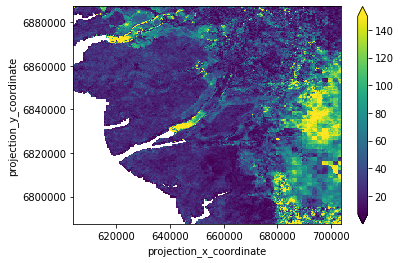

Max amplitude: <xarray.DataArray ()>
array(2163.85844673), Min amplitude: <xarray.DataArray ()>
array(0.09081252)


In [1132]:
new_amps3 = np.reshape(amps, (len(x), len(y)))
all_amps3 = xr.DataArray(new_amps3, dims=("x", "y"), coords={'x':x, 'y':y})

all_amps3.plot(x='x', y='y', robust=True)
plt.show()
print(f"Max amplitude: {np.max(all_amps3)}, Min amplitude: {np.min(all_amps3)}")

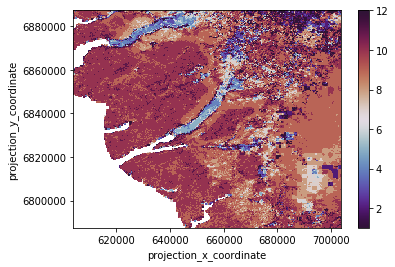

In [1133]:
new_peaks3 = (np.array(peaks.astype(float)) + datetime.date(2000, 1, 1).toordinal())
all_peaks3 = np.array([datetime.date.fromordinal(p.astype(int)) if np.isnan(p)==False else p for p in new_peaks3])

peak_months3 = np.array([p if type(p)==np.float64 else p.month for p in all_peaks3])
peak_months3 = np.reshape(peak_months3, (len(x), len(y)))
peak_months3 = xr.DataArray(peak_months3, dims=("x", "y"), coords={'x':x, 'y':y})

peak_months3.plot(x='x', y='y', cmap='twilight_shifted')
plt.show()

In [1134]:
np.savetxt("true_amps.csv", amps, delimiter=",")

In [1135]:
np.savetxt("true_peaks.csv", peaks, delimiter=",")

In [1136]:
np.savetxt("true_phases.csv", phases, delimiter=",")